In [2]:
#Import Necessary libraries
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as TF
from torchvision import transforms
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from tqdm import tqdm

In [2]:
#will use drakbackground style for plotting (images are also with black bg)
plt.style.use("dark_background")

In [3]:
#define dataset folder path
PATH = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/"

In [4]:
#create dataframe to store image and mask paths
df = pd.DataFrame()

Each folder contains MR images with the following naming convention:  

```TCGA_<institution-code>_<patient-id>_<slice-number>.tif```  
So, we will use glob to get all mask image paths and then remove "mask" from path to get image path

In [5]:
df["mask_file"] = glob.glob(PATH+"*/*_mask.tif")
df["img_file"] = [path.replace("_mask","") for path in df["mask_file"]]

In [6]:
def get_patient_id(paths):
    """Function to extract patient unique id from mask image path"""
    return [path.split("/")[-2] for path in paths]

In [7]:
#add patient id column to dataframe
df["patient_id"] = get_patient_id(df["mask_file"])

In [8]:
def get_label(path):
    """Check if there is any mask on mask image or not to get label(tumor or not)"""
    mask = Image.open(path)
    mask = np.asarray(mask)
    
    return int(mask.max() > 0)

In [9]:
df["is_tumor"] = df["mask_file"].apply(get_label)

In [10]:
# rearranging columns, just to make it look preetty
df = df.iloc[:,[2,1,0,3]]

In [11]:
df.head()

,patient_id,img_file,mask_file,is_tumor
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1


In [12]:
#checking if mask path and image paths matches 
rand_idx = torch.randint(1,10,(1,)).item()
df.iloc[rand_idx].values

array(['TCGA_DU_7010_19860307',
       '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_43.tif',
       '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_43_mask.tif',
       1], dtype=object)

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [14]:
class RandomHFlip():
    """Performs random horizontal flip with given probaility"""
    def __init__(self,p=0.5):
        self.prob = p
    
    def __call__(self, pair):
        img,mask = pair
        if torch.rand((1,)).item() > self.prob:
            img,mask = TF.hflip(img), TF.hflip(mask)
        
        return img,mask

In [15]:
class RandomAffine():
    """Performs random affine transformation(rotate, translate, scaling and shear) with given probaility"""
    def __init__(self, degrees=None, translate=None, scale_ranges=None, shears=None):
        self.params = {
                'degrees': degrees,
                'translate': translate,
                'scale_ranges': scale_ranges,
                'shears': shears
        }
    
    def __call__(self, pair):
        img, mask = pair
        w, h = img.size
        
        #get parameters for random affine transformations
        angle, translations, scale, shear = transforms.RandomAffine.get_params(self.params['degrees'], self.params['translate'], self.params['scale_ranges'], self.params['shears'], (w,h))
        
        # apply TF.affine using fixed parameters
        img = TF.affine(img, angle, translations, scale, shear)
        mask = TF.affine(mask, angle, translations, scale, shear)
        return img, mask

class ToTensorPair():
    """Convert PIL image to tensor, also does normalization"""
    def __call__(self,pair):
        img,mask = pair
        img,mask = transforms.ToTensor()(img), transforms.ToTensor()(mask)
        
        return img,mask

In [16]:
transform = transforms.Compose([
    RandomHFlip(),
    RandomAffine((-10,10),(0.1,0.1),(1,1.3),(-7,7)),
    ToTensorPair()
    
])

In [17]:
class MyDataset(Dataset):
    """Custom dataset to load image pask pair"""
    def __init__(self,df,transform):
        self.images = df["img_file"]
        self.masks = df["mask_file"]
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        image = Image.open(self.images[idx])
        mask = Image.open(self.masks[idx])
        
        image,mask = self.transform((image, mask))
#         mask = self.transform(mask)
        return image,mask

In [18]:
dataset = MyDataset(df,transform)

In [19]:
def show_sample(pair):
    img,mask = pair
    plt.subplot(1,2,1)
    plt.imshow(img.permute(1,2,0))
    
    plt.subplot(1,2,2)
    plt.imshow(mask.permute(1,2,0))
    plt.show()

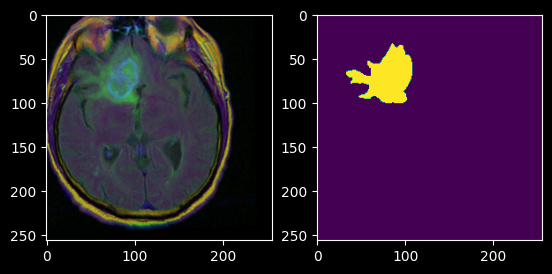

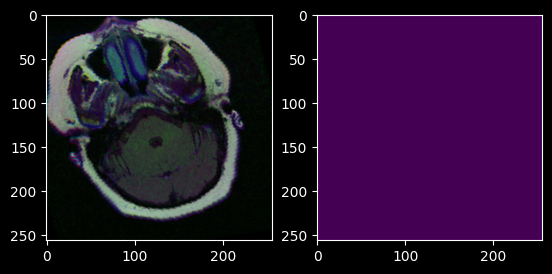

In [20]:
for x in range(2):
    i = torch.randint(1,len(dataset),(1,)).item()
    show_sample(dataset[i])

In [21]:
#split dataset into train and validation set
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

In [22]:
BATCH_SIZE = 16

In [23]:
train_loader =  DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader =  DataLoader(val_dataset, batch_size=BATCH_SIZE)

## Nested UNet (UNet++)
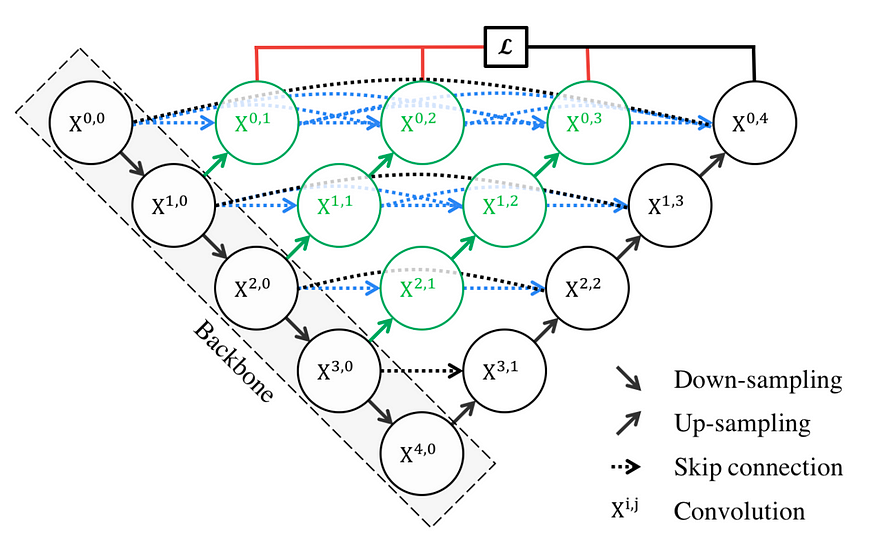

In [3]:
class DoubleConv(nn.Module):
    """Basic Block for UNet"""
    def __init__(self,in_channels,out_channels):
        super(DoubleConv, self).__init__()
            
        self.dconv =  nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
      )
    
    def forward(self,x):
        return self.dconv(x)

In [8]:
class NestedUNet(nn.Module):
    def __init__(self):
        super(NestedUNet, self).__init__()
        
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv0_0 = DoubleConv(3,32)
        self.conv1_0 = DoubleConv(32,64)
        self.conv2_0 = DoubleConv(64, 128)
        self.conv3_0 = DoubleConv(128, 256)
        self.conv4_0 = DoubleConv(256,512)
        
        self.conv0_1 = DoubleConv(32+64, 32)
        self.conv1_1 = DoubleConv(64+128, 64)
        self.conv2_1 = DoubleConv(128+256, 128)
        self.conv3_1 = DoubleConv(256+512, 256)
        
        self.conv0_2 = DoubleConv(2*32+64, 32)
        self.conv1_2 = DoubleConv(2*64+128, 64)
        self.conv2_2 = DoubleConv(2*128+256, 128)
        
        self.conv0_3 = DoubleConv(3*32+64, 32)
        self.conv1_3 = DoubleConv(3*64+128, 64)
        
        self.conv0_4 = DoubleConv(4*32+64, 32)
        
        self.op1 = nn.Conv2d(32, 1, kernel_size=(1, 1))
        self.op2 = nn.Conv2d(32, 1, kernel_size=(1, 1))
        self.op3 = nn.Conv2d(32, 1, kernel_size=(1, 1))
        self.op4 = nn.Conv2d(32, 1, kernel_size=(1, 1))
    
    def forward(self,x):
        x0_0 = self.conv0_0(x)
#         print("x0_0:",x0_0.shape)
        x1_0 = self.conv1_0(self.pool(x0_0))
#         print("x1_0:",x1_0.shape)
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)],1))
#         print("x0_1:",x0_1.shape)
        
        x2_0 = self.conv2_0(self.pool(x1_0))
#         print("x2_0:",x2_0.shape)
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)],1))
#         print("x1_1:",x1_1.shape)
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)],1))
#         print("x0_2:",x0_2.shape)
        
        x3_0 = self.conv3_0(self.pool(x2_0))
#         print("x3_0:",x3_0.shape)
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)],1))
#         print("x2_1:",x2_1.shape)
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)],1))
#         print("x1_2:",x1_2.shape)
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)],1))
#         print("x0_3:",x0_3.shape)
        
        x4_0 = self.conv4_0(self.pool(x3_0))
#         print("x4_0:",x4_0.shape)
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)],1))
#         print("x3_1:",x3_1.shape)
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)],1))
#         print("x2_2:",x2_2.shape)
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)],1))
#         print("x1_3:",x1_3.shape)
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)],1))
#         print("x0_4:",x0_4.shape)
        
        op1 = self.op1(x0_1)
        op2 = self.op1(x0_2)
        op3 = self.op1(x0_3)
        op4 = self.op1(x0_4)
        
        return [op1,op2,op3,op4]

In [9]:
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = BCEWithLogitsLoss()

    def forward(self, input, target):
        bce = self.bce(input, target)
        smooth = 1e-5
        input = torch.sigmoid(input)
        num = target.size(0)
        input = input.view(num, -1)
        target = target.view(num, -1)
        intersection = (input * target)
        dice = (2. * intersection.sum(1) + smooth) / (input.sum(1) + target.sum(1) + smooth)
        dice = 1 - dice.sum() / num
        return 0.5 * bce + dice

In [10]:
def iou_score(output, target):
    smooth = 1e-5

    if torch.is_tensor(output):
        output = torch.sigmoid(output).data.cpu().numpy()
    if torch.is_tensor(target):
        target = target.data.cpu().numpy()
    output_ = output > 0.5
    target_ = target > 0.5
    intersection = (output_ & target_).sum()
    union = (output_ | target_).sum()

    return (intersection + smooth) / (union + smooth)

In [11]:
def train(model,EPOCHS,train_loader,val_loader, criterion,lr = 0.001,):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_n = len(train_loader)

    optimizer = Adam(model.parameters(), lr=lr)
    model = model.to(device)

    train_loss = []
    val_loss = [0]
    val_iou,train_iou = [0], []

    for epoch in range(EPOCHS):
        model.train(True)
        pbar = tqdm(train_loader)

        batch_loss = []
        batch_iou = []
        
        for i,data in enumerate(pbar):
            inputs,labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Make predictions for this batch
            outputs = model(inputs)
            # Compute the loss and its gradients
            loss = 0
            for op in outputs:
                loss += criterion(op, labels)
            loss /= len(outputs)
            iou = iou_score(outputs[-1], labels)
            
            loss.backward()

            batch_loss.append(loss.item())
            batch_iou.append(iou)
            
            optimizer.step()

            pbar.set_description(f"Epoch: {epoch + 1}/{EPOCHS}; Train Loss: {round(np.mean(batch_loss),3)};\
            Val Loss: {round(val_loss[-1],3)}; Train_IOU: {round(np.mean(batch_iou),3)}; Val_IOU: {round(val_iou[-1],3)}")

          # Set the model to evaluation mode, disabling dropout and using population
          # statistics for batch normalization.
        model.eval()
        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            val_batch_loss = []
            val_batch_iou = []
            
            for i, vdata in enumerate(val_loader):
                vinputs, vlabels = vdata
                vinputs = vinputs.to(device)
                vlabels = vlabels.to(device)
                voutputs = model(vinputs)
                vloss = 0
                for vop in voutputs:
                    vloss += criterion(vop, vlabels).item()
                vloss /= len(voutputs)
                iou_val = iou_score(voutputs[-1], vlabels)
                val_batch_loss.append(vloss)

        val_loss.append(np.mean(val_batch_loss))
        val_iou.append(np.mean(val_batch_iou))
        train_loss.append(np.mean(batch_loss))
        train_iou.append(np.mean(batch_iou))

    return train_loss,val_loss, train_iou,val_iou

In [12]:
model = NestedUNet()

In [30]:
EPOCHS = 100

In [31]:
train_loss,val_loss,train_iou,val_iou  = train(model,EPOCHS,train_loader,val_loader,BCEDiceLoss(),lr=3e-5)

Epoch: 1/100; Train Loss: 1.202;            Val Loss: 0; Train_IOU: 0.288; Val_IOU: 0: 100%|██████████| 197/197 [02:10<00:00,  1.51it/s]
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Epoch: 2/100; Train Loss: 1.153;            Val Loss: 1.175; Train_IOU: 0.416; Val_IOU: nan: 100%|██████████| 197/197 [01:49<00:00,  1.81it/s]
Epoch: 3/100; Train Loss: 1.132;            Val Loss: 1.134; Train_IOU: 0.497; Val_IOU: nan: 100%|██████████| 197/197 [01:49<00:00,  1.80it/s]
Epoch: 4/100; Train Loss: 1.116;            Val Loss: 1.129; Train_IOU: 0.537; Val_IOU: nan: 100%|██████████| 197/197 [01:49<00:00,  1.80it/s]
Epoch: 5/100; Train Loss: 1.101;            Val Loss: 1.102; Train_IOU: 0.571; Val_IOU: nan: 100%|██████████| 

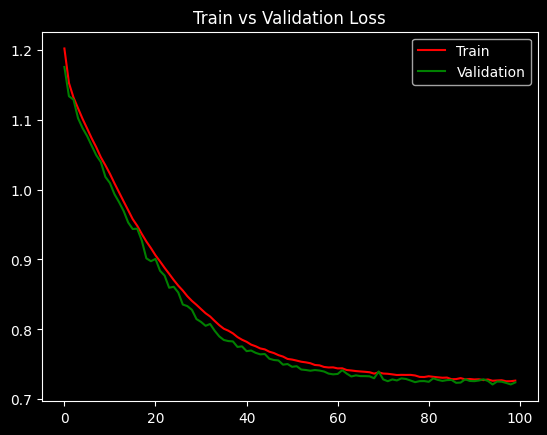

In [32]:
plt.plot(list(range(EPOCHS)),train_loss,c="red")
plt.plot(list(range(EPOCHS)),val_loss[1:],c="green")
plt.legend(["Train","Validation"])
plt.title("Train vs Validation Loss")
plt.show()

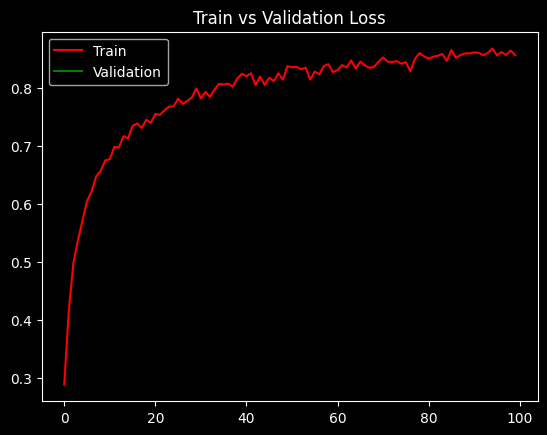

In [33]:
plt.plot(list(range(EPOCHS)),train_iou,c="red")
plt.plot(list(range(EPOCHS)),val_iou[1:],c="green")
plt.legend(["Train","Validation"])
plt.title("Train vs Validation Loss")
plt.show()
#IOU not Loss :)

In [34]:
def random_pred(thresh=0.7):
    with torch.no_grad():
        samp = val_dataset[torch.randint(1,400,(1,))[0].item()]
        img = samp[0].to(device)
        mask = samp[1]
        op = model(img.unsqueeze(0))#.cpu().squeeze(0)
        op = [torch.sigmoid(y.cpu().squeeze(0)) for y in op]
#         op = torch.sigmoid(op)
        op = [(y>thresh).int() for y in op]
        
        plt.figure(figsize = (15,7))
        plt.subplot(1,6,1)
        plt.imshow(img.cpu().permute(1,2,0),cmap="gray")
        plt.title("MRI Image")
        plt.axis("off")

        plt.subplot(1,6,2)
        plt.imshow(mask.permute(1,2,0),cmap="gray")
        plt.title("Original Mask")
                
        plt.axis("off")
        for i in range(len(op)):
            plt.subplot(1,6,i+3)
            plt.imshow(op[i].permute(1,2,0),cmap="gray")
            plt.title(f"Pred-layer{i+1}")
            plt.axis("off")
        
        plt.show()

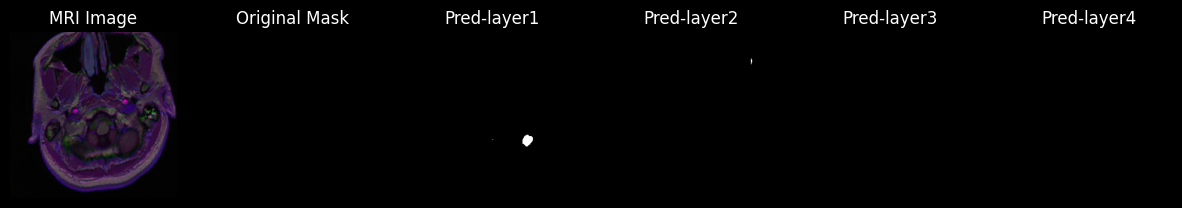

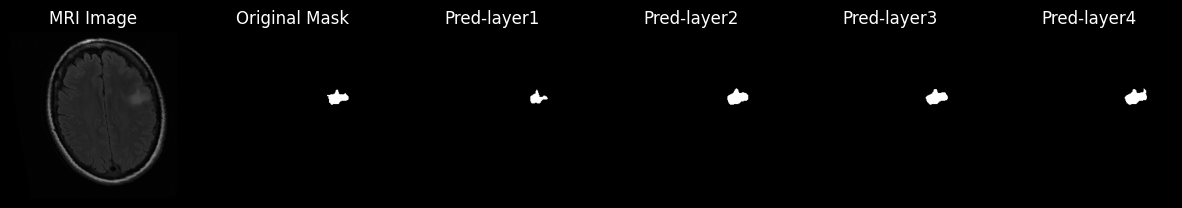

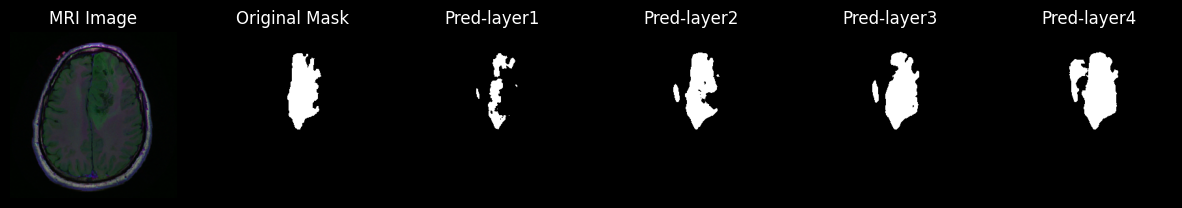

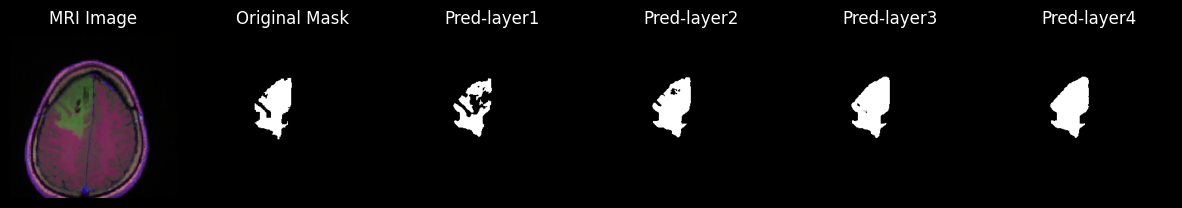

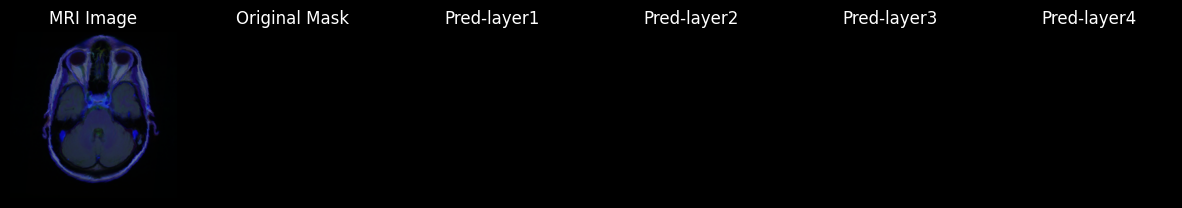

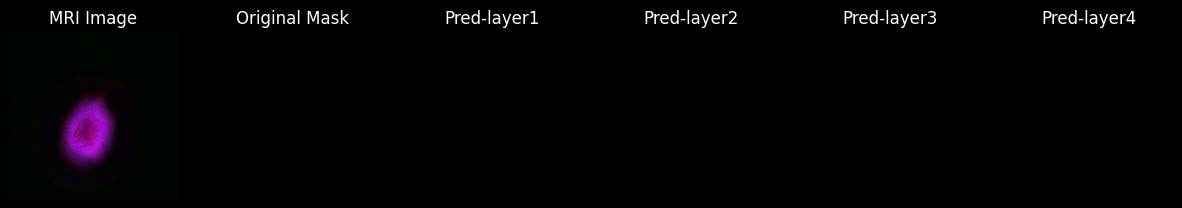

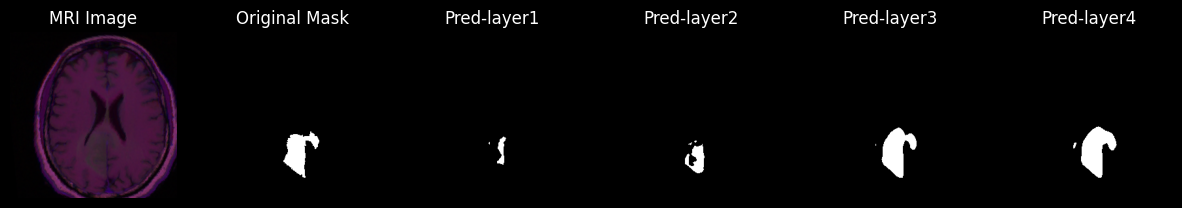

In [35]:
for i in range(7):
    random_pred()

In [36]:
torch.save(model.state_dict(), "model.pt")

In [37]:
# x = torch.rand((32,3,256,256))
# op = model2(x)

In [38]:
# op.shape

In [39]:
# with torch.no_grad():
#     plt.imshow(op[12].permute(1,2,0),cmap="gray")